# Preparation

In [117]:
from vision_counter import CounTR
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.models.yolov8.yolo import load_yolov8_detector
from src.models.yolov8.yolo import yolov8_detect

from src.features.preprocessing import preprocess
from src.models.watershed.markers import get_markers

In [118]:
image_path = r".\data\test_data\metrics\images\30.png"
mask_path = r".\data\test_data\metrics\masks\30.png"

In [119]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [120]:
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# YOLOv8 objects counting

In [121]:
custom_yolo_checkpoint_path = r".\notebooks\yolo\runs\detect\train4mbetter\weights\yolov8m_all_bubbles_best.pt"

In [122]:
detector = load_yolov8_detector(custom_yolo_checkpoint_path)
bboxes = yolov8_detect(image=image, detector=detector, return_objects=False)

0: 480x640 146 bubbles, 20.0ms
Speed: 4.0ms preprocess, 20.0ms inference, 13.0ms postprocess per image at shape (1, 3, 480, 640)


In [123]:
points = np.array([np.array([int((bbox[0] + bbox[2])/2), int((bbox[1] + bbox[3])/2)]) for bbox in bboxes])

In [124]:
points

array([[243, 366],
       [631, 168],
       [618, 394],
       [256, 432],
       [516, 150],
       [528,  55],
       [426, 432],
       [209, 273],
       [439, 234],
       [171, 243],
       [ 55, 337],
       [152, 431],
       [467, 123],
       [350,  90],
       [603, 496],
       [560, 409],
       [204, 410],
       [258,  71],
       [350, 348],
       [ 96, 195],
       [393, 406],
       [556, 519],
       [525,  22],
       [428, 485],
       [378, 313],
       [721, 283],
       [411, 133],
       [666, 236],
       [428, 297],
       [243, 313],
       [596, 540],
       [692, 267],
       [ 36, 323],
       [674, 485],
       [757, 164],
       [350, 384],
       [638, 419],
       [640, 311],
       [648, 479],
       [465, 420],
       [517, 311],
       [403, 470],
       [690, 161],
       [184,  62],
       [131, 428],
       [413, 335],
       [299, 446],
       [422,  90],
       [ 97, 465],
       [502, 555],
       [655, 446],
       [244,  64],
       [717,

In [125]:
points[:,0]

array([243, 631, 618, 256, 516, 528, 426, 209, 439, 171,  55, 152, 467, 350, 603, 560, 204, 258, 350,  96, 393, 556, 525, 428, 378, 721, 411, 666, 428, 243, 596, 692,  36, 674, 757, 350, 638, 640, 648, 465, 517, 403, 690, 184, 131, 413, 299, 422,  97, 502, 655, 244, 717, 675, 768, 113, 180, 657, 116, 528, 434, 308,
       329, 261, 181, 529, 550, 270, 475, 489, 288,  43, 382, 743, 167, 159,  70, 137,  56, 231, 311, 419, 715, 711, 337, 546, 191, 589, 656, 736, 709, 117, 632, 349, 233, 719, 586,  75, 469, 385, 335, 176, 456, 650, 386, 641,  93, 585, 231, 565, 634, 334, 480, 197, 156, 553, 331, 305, 153,  58, 345, 132, 214,  71,
       357,  31, 353, 371, 723, 341, 627, 488,  58, 754, 303, 382, 493, 676, 655, 577, 205, 418, 618, 323, 452, 289])

In [126]:
img_to_show = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

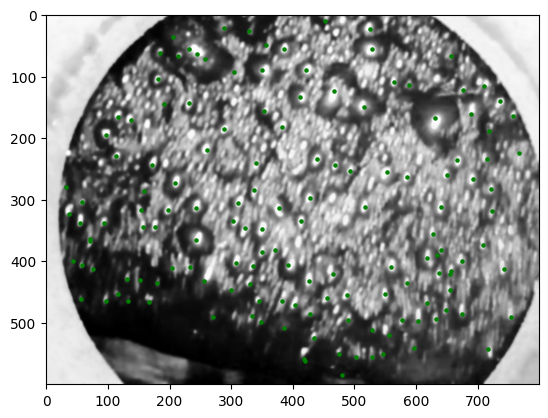

In [127]:
plt.imshow(img_to_show, cmap='gray')
plt.scatter(points[:, 0], points[:, 1], s=5, c='green')
plt.show()

# Otsu contours counting

In [128]:
preprocessed_image = preprocess(image)
markers = get_markers('all', preprocessed_image)

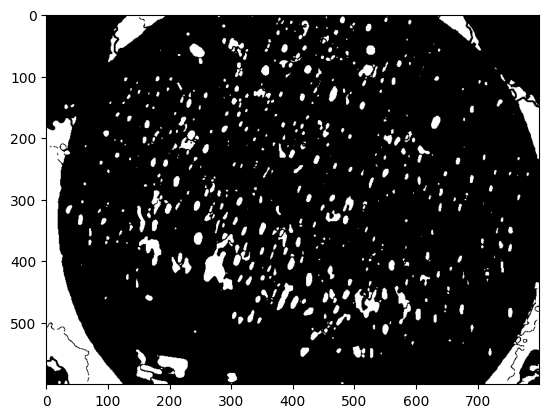

In [129]:
plt.imshow(markers)

In [130]:
markers = cv2.cvtColor(markers, cv2.COLOR_BGR2GRAY)

In [131]:
blank = np.zeros(image.shape, dtype='uint8')
contours, hierarchy = cv2.findContours(markers, 
          cv2.RETR_TREE,   cv2.CHAIN_APPROX_SIMPLE)

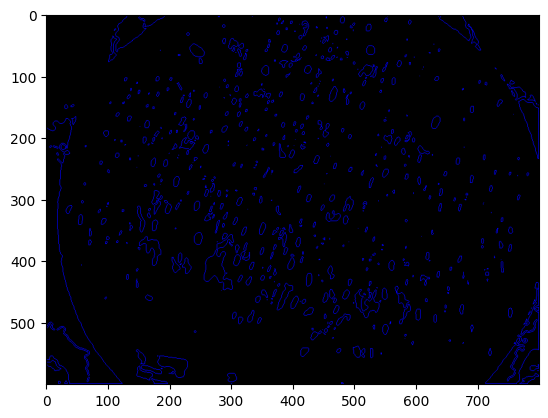

In [132]:
cv2.drawContours(blank, contours, -1, (0, 0, 255), 1)
plt.imshow(blank)

In [135]:
def find_contours_centers(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            centers.append(np.array([cx, cy]))
        
    return np.array(centers)

In [136]:
centers = find_contours_centers(contours)

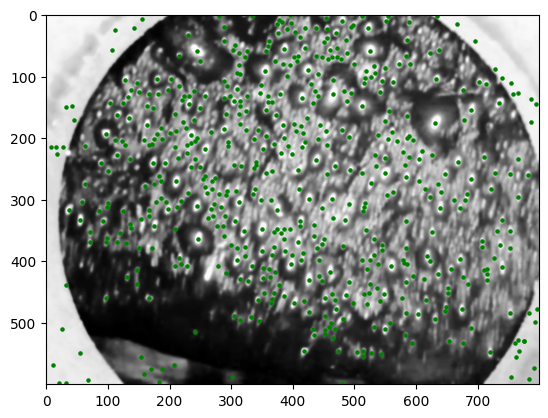

In [137]:
plt.imshow(img_to_show, cmap='gray')
plt.scatter(centers[:, 0], centers[:, 1], s=5, c='green')
plt.show()

# Objects recall

In [165]:
TPFN = centers.shape[0]

In [166]:
TP1 = 0
for center in centers:
    if mask[center[1]][center[0]] != 0:
        TP1 += 1

In [167]:
print("MASK")
print(f"TP: {TP1}")
print(f"TP + FN: {TPFN}")
print(f"Objects recall: {TP1/TPFN}")

MASK
TP: 483
TP + FN: 553
Objects recall: 0.8734177215189873


In [168]:
label_path = r".\data\test_data\metrics\label\30.png"
label = cv2.imread(label_path)
label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)

In [169]:
TP2 = 0
for center in centers:
    if label[center[1]][center[0]] != 0:
        TP2 += 1

In [170]:
print("LABEL")
print(f"TP: {TP2}")
print(f"TP + FN: {TPFN}")
print(f"Objects recall: {TP2/TPFN}")

LABEL
TP: 150
TP + FN: 553
Objects recall: 0.27124773960216997
